# Multilayer Perceptron

In the previous chapters, we showed how you could implement multiclass logistic regression (also called softmax regression)
for classifying images of clothing into the 10 possible categories.
To get there, we had to learn how to wrangle data,
coerce our outputs into a valid probability distribution (via `softmax`),
how to apply an appropriate loss function,
and how to optimize over our parameters.
Now that we’ve covered these preliminaries,
we are free to focus our attention on
the more exciting enterprise of designing powerful models
using deep neural networks.

## Hidden Layers

Recall that for linear regression and softmax regression,
we mapped our inputs directly to our outputs
via a single linear transformation:

$$
\hat{\mathbf{o}} = \mathrm{softmax}(\mathbf{W} \mathbf{x} + \mathbf{b})
$$

If our labels really were related to our input data
by an approximately linear function, then this approach would be perfect.
But linearity is a *strong assumption*.
Linearity implies that for whatever target value we are trying to predict,
increasing the value of each of our inputs
should either drive the value of the output up or drive it down,
irrespective of the value of the other inputs.

Sometimes this makes sense!
Say we are trying to predict whether an individual
will or will not repay a loan.
We might reasonably imagine that all else being equal,
an applicant with a higher income
would be more likely to repay than one with a lower income.
In these cases, linear models might perform well,
and they might even be hard to beat.

But what about classifying images in FashionMNIST?
Should increasing the intensity of the pixel at location (13,17)
always increase the likelihood that the image depicts a pocketbook?
That seems ridiculous because we all know
that you cannot make sense out of an image
without accounting for the interactions among pixels.



### From one to many

As another case, consider trying to classify images
based on whether they depict *cats* or *dogs* given black-and-white images.

If we use a linear model, we'd basically be saying that
for each pixel, increasing its value (making it more white)
must always increase the probability that the image depicts a dog
or must always increase the probability that the image depicts a cat.
We would be making the absurd assumption that the only requirement
for differentiating cats vs. dogs is to assess how bright they are.
That approach is doomed to fail in a work
that contains both black dogs and black cats,
and both white dogs and white cats.

Teasing out what is depicted in an image generally requires
allowing more complex relationships between our inputs and outputs.
Thus we need models capable of discovering patterns
that might be characterized by interactions among the many features.
We can over come these limitations of linear models
and handle a more general class of functions
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many layers of neurons on top of each other.
Each layer feeds into the layer above it, until we generate an output.
This architecture is commonly called a *multilayer perceptron*,
often abbreviated as *MLP*.
The neural network diagram for an MLP looks like this:

The multilayer perceptron above has 4 inputs and 3 outputs,
and the hidden layer in the middle contains 5 hidden units.
Since the input layer does not involve any calculations,
building this network would consist of
implementing 2 layers of computation.
The neurons in the input layer are fully connected
to the inputs in the hidden layer.
Likewise, the neurons in the hidden layer
are fully connected to the neurons in the output layer.


### From linear to nonlinear

We can write out the calculations that define this one-hidden-layer MLP in mathematical notation as follows:
$$
\begin{aligned}
    \mathbf{h} & = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o})
\end{aligned}
$$

By adding another layer, we have added two new sets of parameters,
but what have we gained in exchange?
In the model defined above, we do not achieve anything for our troubles!

That's because our hidden units are just a linear function of the inputs
and the outputs (pre-softmax) are just a linear function of the hidden units.
A linear function of a linear function is itself a linear function.
That means that for any values of the weights,
we could just collapse out the hidden layer
yielding an equivalent single-layer model using
$\mathbf{W} = \mathbf{W}_2 \mathbf{W}_1$ and $\mathbf{b} = \mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2$.

$$\mathbf{o} = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 = \mathbf{W}_2 (\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2 = (\mathbf{W}_2 \mathbf{W}_1) \mathbf{x} + (\mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2) = \mathbf{W} \mathbf{x} + \mathbf{b}$$

In order to get a benefit from multilayer architectures,
we need another key ingredient—a nonlinearity $\sigma$ to be applied to each of the hidden units after each layer's linear transformation.
The most popular choice for the nonlinearity these days is the rectified linear unit (ReLU) $\mathrm{max}(x,0)$.
After incorporating these non-linearities
it becomes impossible to merge layers.

$$
\begin{aligned}
    \mathbf{h} & = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o})
\end{aligned}
$$

Clearly, we could continue stacking such hidden layers,
e.g. $\mathbf{h}_1 = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$
and $\mathbf{h}_2 = \sigma(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2)$
on top of each other to obtain a true multilayer perceptron.

Multilayer perceptrons can account for complex interactions in the inputs
because the hidden neurons depend on the values of each of the inputs.
It’s easy to design a hidden node that does arbitrary computation,
such as, for instance, logical operations on its inputs.
Moreover, for certain choices of the activation function
it’s widely known that multilayer perceptrons are universal approximators.
That means that even for a single-hidden-layer neural network,
with enough nodes, and the right set of weights,
we can model any function at all!
*Actually learning that function is the hard part.*

Moreover, just because a single-layer network *can* learn any function
doesn't mean that you should try to solve all of your problems with single-layer networks.
It turns out that we can approximate many functions
much more compactly if we use deeper (vs wider) neural networks.
We’ll get more into the math in a subsequent chapter,
but for now let’s actually build an MLP.
In this example, we’ll implement a multilayer perceptron
with two hidden layers and one output layer.

### Vectorization and mini-batch

As before, by the matrix $\mathbf{X}$, we denote a mini-batch of inputs.
The calculations to produce outputs from an MLP with two hidden layers
can thus be expressed:

$$
\begin{aligned}
    \mathbf{H}_1 & = \sigma(\mathbf{W}_1 \mathbf{X} + \mathbf{b}_1) \\
    \mathbf{H}_2 & = \sigma(\mathbf{W}_2 \mathbf{H}_1 + \mathbf{b}_2) \\
    \mathbf{O} & = \mathrm{softmax}(\mathbf{W}_3 \mathbf{H}_2 + \mathbf{b}_3)
\end{aligned}
$$

With some abuse of notation, we define the nonlinearity $\sigma$
to apply to its inputs on a row-wise fashion, i.e. one observation at a time.
Note that we are also using the notation for *softmax* in the same way to denote a row-wise operation.
Often, as in this chapter, the activation functions that we apply to hidden layers are not merely row-wise, but component wise.
That means that after computing the linear portion of the layer,
we can calculate each nodes activation without looking at the values taken by the other hidden units.
This is true for most activation functions
(the batch normalization operation will be introduced in :numref:`chapter_batch_norm` is a notable exception to that rule).

## Activation Functions

Because they are so fundamental to deep learning, before going further,
let's take a brief look at some common activation functions.

### ReLU Function

As stated above, the most popular choice,
due to its simplicity of implementation
and its efficacy in training is the rectified linear unit (ReLU).
ReLUs provide a very simple nonlinear transformation.
Given the element $z$, the function is defined
as the maximum of that element and 0.

$$\mathrm{ReLU}(z) = \max(z, 0).$$

It can be understood that the ReLU function retains only positive elements and discards negative elements (setting those nodes to 0).
To get a better idea of what it looks like, we can plot it.
For convenience, we define a plotting function `xyplot`
to take care of the groundwork.

In [0]:
import sys
sys.path.insert(0, '..')

import numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

def xyplot(x_vals,y_vals,name):
    x_vals = x_vals.detach().numpy() # we can't directly use var.numpy() because varibles might 
    y_vals = y_vals.detach().numpy() # already required grad.,thus using var.detach().numpy() 
    plt.plot(x_vals,y_vals) 
    plt.xlabel('x')
    plt.ylabel(name+'(x)')

Since relu is commomly used as activation function, PyTorch supports
the `relu` function as a basic native operator.
As you can see, the activation function is piece-wise linear.


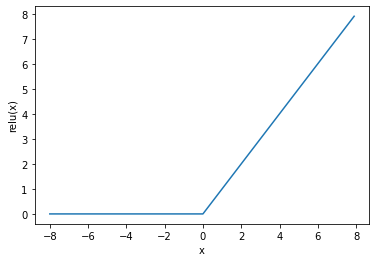

In [0]:
x = Variable(torch.arange(-8.0,8.0,0.1,dtype=torch.float32).reshape(int(16/0.1),1), requires_grad=True)
y = torch.nn.functional.relu(x)
xyplot(x,y,'relu')

When the input is negative, the derivative of ReLU function is 0
and when the input is positive, the derivative of ReLU function is 1.
Note that the ReLU function is not differentiable
when the input takes value precisely equal to  0.
In these cases, we go with the left-hand-side (LHS) derivative
and say that the derivative is 0 when the input is 0.
We can get away with this because the input may never actually be zero.
There's an old adage that if subtle boundary conditions matter,
we are probably doing (*real*) mathematics, not engineering.
That conventional wisdom may apply here.
See the derivative of the ReLU function plotted below.

When we use .backward(), by default it is .backward(torch.Tensor([1])).This is useful when we are dealing with single scalar input.But here we are dealing with a vector input so we have to use this snippet.

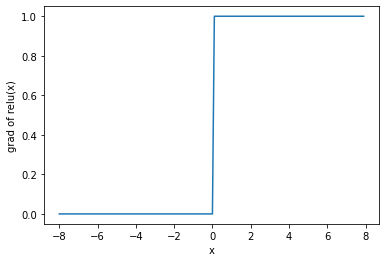

In [0]:
y.backward(torch.ones_like(x), retain_graph=True)
xyplot(x,x.grad,"grad of relu")

Note that there are many variants to the ReLU function, such as the parameterized ReLU (pReLU) of [He et al., 2015](https://arxiv.org/abs/1502.01852). This variation adds a linear term to the ReLU, so some information still gets through, even when the argument is negative.

$$\mathrm{pReLU}(x) = \max(0, x) + \alpha \min(0, x)$$

The reason for using the ReLU is that its derivatives are particularly well behaved - either they vanish or they just let the argument through. This makes optimization better behaved and it reduces the issue of the vanishing gradient problem (more on this later).

### Sigmoid Function

The sigmoid function transforms its inputs which take values in $\mathbb{R}$ to the interval $(0,1)$.
For that reason, the sigmoid is often called a *squashing* function:
it squashes any input in the range (-inf, inf)
to some value in the range (0,1).

$$\mathrm{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
which either *fire* or *don't fire*.
Thus the pioneers of this field, going all the way back to McCulloch and Pitts in the 1940s, were focused on thresholding units.
A thresholding function takes either value $0$
(if the input is below the threshold)
or value $1$ (if the input exceeds the threshold)


When attention shifted to gradient based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable approximation to a thresholding unit.
Sigmoids are still common as activation functions on the output units,
when we want to interpret the outputs as probabilities
for binary classification problems
(you can think of the sigmoid as a special case of the softmax)
but the sigmoid has mostly been replaced by the simpler and easier to train ReLU for most use in hidden layers.
In the "Recurrent Neural Network" chapter, we will describe
how sigmoid units can be used to control
the flow of information in a neural network
thanks to its capacity to transform the value range between 0 and 1.

See the sigmoid function plotted below.
When the input is close to 0, the sigmoid function
approaches a linear transformation.


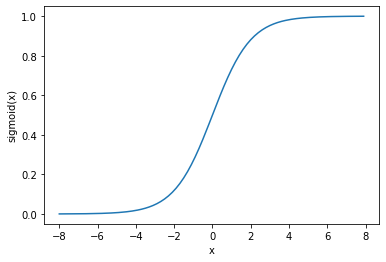

In [0]:
x = Variable(torch.arange(-8.0,8.0,0.1, dtype=torch.float32).reshape(int(16/0.1),1), requires_grad=True)
y = torch.sigmoid(x)
xyplot(x,y,'sigmoid')

The derivative of sigmoid function is given by the following equation:

$$\frac{d}{dx} \mathrm{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \mathrm{sigmoid}(x)\left(1-\mathrm{sigmoid}(x)\right).$$


The derivative of sigmoid function is plotted below.
Note that when the input is 0, the derivative of the sigmoid function
reaches a maximum of 0.25. As the input diverges from 0 in either direction, the derivative approaches 0.


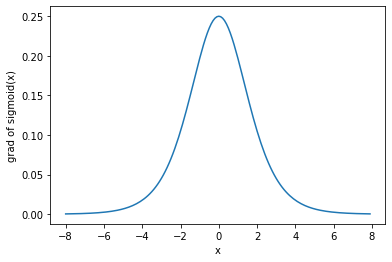

In [0]:
y.backward(torch.ones_like(x), retain_graph=True)
xyplot(x,x.grad,'grad of sigmoid')

### Tanh Function

Like the sigmoid function, the tanh (Hyperbolic Tangent)
function also squashes its inputs,
transforms them into elements on the interval between -1 and 1:

$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function blow. Note that as the input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.


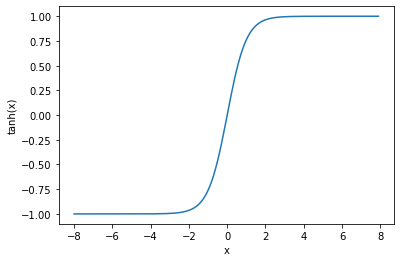

In [0]:
x = Variable(torch.arange(-8.0,8.0,0.1, dtype=torch.float32).reshape(int(16/0.1),1), requires_grad=True)
y = torch.tanh(x)
xyplot(x,y,"tanh")

The derivative of the Tanh function is:

$$\frac{d}{dx} \mathrm{tanh}(x) = 1 - \mathrm{tanh}^2(x).$$

The derivative of tanh function is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as the input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.

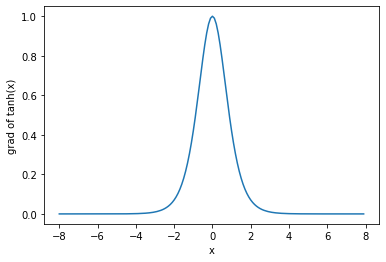

In [0]:
y.backward(torch.ones_like(x), retain_graph=True)
xyplot(x,x.grad,"grad of tanh")

In summary, we now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge now already
puts you in command of the state of the art in deep learning, circa 1990.
In fact, you have an advantage over anyone working the 1990s,
because you can leverage powerful open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, getting these nets training
required researchers to code up thousands of lines of C and Fortran.

## Summary

* The multilayer perceptron adds one or multiple fully-connected hidden layers between the output and input layers and transforms the output of the hidden layer via an activation function.
* Commonly-used activation functions include the ReLU function, the sigmoid function, and the tanh function.

# Concise Implementation of Multilayer Perceptron

Now that we learned how multilayer perceptrons (MLPs) work in theory, let’s implement them. We begin, as always, by
importing modules.

In [0]:
import sys
sys.path.insert(0, '..')
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# The Model

The only difference from our softmax regression implementation is that we add two Dense (fully-connected) layers
instead of one. The first is our hidden layer, which has 256 hidden units and uses the ReLU activation function.

In [0]:
class Net(nn.Module):
    def __init__(self, num_inputs = 784, num_outputs = 10, num_hiddens = 256, is_training = True):
        super(Net, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        
        self.layer1 = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU())
        self.layer2 = nn.Linear(num_hiddens, num_outputs)

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1 = self.layer1(X)
        out = self.layer2(H1)
        return out

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)        
        m.bias.data.fill_(0.01)

# Create an instance of the MLP
net = Net()
net.apply(init_weights)
print(net) 

Net(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer2): Linear(in_features=256, out_features=10, bias=True)
)


Load the Fashion MNIST Dataset.

In [0]:
# By default pytorch torchvision datasets are of type PIL.
# Define a transform "trans" to change the PIL to Tensor format.
trans = transforms.ToTensor() 

mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Create the Data Loaders for the training and test data

In [0]:
batch_size = 256
if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
else:
    num_workers = 4

train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)

Set the Model Configurations: Number of epochs, learning rate (lr) and the batch-size. 
Defining the Loss (criterion)

In [0]:
num_epochs, lr, batch_size = 10, 0.5, 256
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = lr)

Training the model follows the exact same steps as in our softmax regression implementation.

In [0]:
for epoch in range(num_epochs): 
  train_loss_epoch = 0.0
  net.train()
  for X, y in train_iter:  
    y_hat = net(X)
    l = criterion(y_hat, y)
    train_loss_epoch += l
    optimizer.zero_grad() 
    l.backward() 
    optimizer.step() 
  train_loss_epoch /= len(train_iter)
  
  net.eval()
  with torch.no_grad():
    test_loss_epoch = 0.0
    for X_test, y_test in test_iter:
      b_l = criterion(net(X_test), y_test) 
      test_loss_epoch += b_l
    test_loss_epoch /= len(test_iter)  
  print('epoch {}, train loss {}, test loss {}'.format(epoch+1, train_loss_epoch, test_loss_epoch)) 

epoch 1, train loss 0.7822871208190918, test loss 0.6922860145568848
epoch 2, train loss 0.48273760080337524, test loss 0.5376869440078735
epoch 3, train loss 0.42822298407554626, test loss 0.5391448140144348
epoch 4, train loss 0.39352673292160034, test loss 0.44217801094055176
epoch 5, train loss 0.3668493330478668, test loss 0.3737078309059143
epoch 6, train loss 0.3480774760246277, test loss 0.49589842557907104
epoch 7, train loss 0.3350205421447754, test loss 0.40118488669395447
epoch 8, train loss 0.3238588571548462, test loss 0.36858826875686646
epoch 9, train loss 0.30935660004615784, test loss 0.4160229563713074
epoch 10, train loss 0.3025900423526764, test loss 0.3861441910266876


**Exercise:** In the network we created above, we have used the ReLU as an activation function for the first layer. Try out different activation functions from the ones we discussed earlier in this notebook. (Keep all other parameters and hyperparameters constant). In the function below, return the value of the test *accuracy* that corresponds to the activation function you found to produce the best result. (*Hint:* You will need to recreate the network from above and then evaluate one activation function each time).

In [0]:
    class Net1(nn.Module):
        def __init__(self, num_inputs = 784, num_outputs = 10, num_hiddens = 256, is_training = True):
            super(Net1, self).__init__()
            
            self.num_inputs = num_inputs
            self.num_outputs = num_outputs
            self.num_hiddens = num_hiddens
           

            self.layer1 = nn.Sequential(
                nn.Linear(num_inputs, num_hiddens),
                nn.ReLU()
                )
            self.layer2 = nn.Linear(num_hiddens, num_outputs)

        def forward(self, X):
            X = X.reshape((-1, self.num_inputs))
            H1 = self.layer1(X)
            #H2 = torch.tanh(H1)
            out = self.layer2(H1)
            return out

    def init_weights(m):
     if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)        
        m.bias.data.fill_(0.01)

    # Create an instance of the MLP
   
    net1 = Net1()
    net1.apply(init_weights)
    print(net1) 

    

Net1(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer2): Linear(in_features=256, out_features=10, bias=True)
)


In [0]:
    net1.apply(init_weights) # this line is to reset the weights of the network
    num_epochs, lr, batch_size = 10, 0.5, 256
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net1.parameters(), lr = lr)
   
    for epoch in range(num_epochs): 
      train_loss_epoch = 0.0
      total = 0
      correct = 0
      net1.train()
      for X, y in train_iter:  
        y_hat = net1(X)
        l = criterion(y_hat, y)
        train_loss_epoch += l
        total += y.size(0)
        correct += (y_hat.argmax(dim=1) == y).sum().item()
        optimizer.zero_grad() 
        l.backward() 
        optimizer.step()
      train_accuracy = correct/total
      train_loss_epoch /= len(train_iter)
    
      net1.eval()
      with torch.no_grad():
        test_loss_epoch = 0.0
        total_test = 0
        correct_test = 0
        for X_test, y_test in test_iter:
          y_test_hat = net1(X_test)
          b_l = criterion(y_test_hat, y_test) 
          test_loss_epoch += b_l
          total_test += y_test.size(0)
          correct_test += (y_test_hat.argmax(dim=1) == y_test).sum().item() 
        test_loss_epoch /= len(test_iter)  
        test_accuracy = correct_test/total_test
      print('epoch {}, train loss {}, train aacuracy{}, test loss {}, test accuracy{}'.format(epoch+1, train_loss_epoch,train_accuracy ,test_loss_epoch,test_accuracy)) 

epoch 1, train loss 0.8138970732688904, train aacuracy0.6993333333333334, test loss 0.5163170099258423, test accuracy0.8062
epoch 2, train loss 0.49108216166496277, train aacuracy0.8182, test loss 0.45148783922195435, test accuracy0.8314
epoch 3, train loss 0.4282894730567932, train aacuracy0.84195, test loss 0.4926125109195709, test accuracy0.8059
epoch 4, train loss 0.3933418393135071, train aacuracy0.8568833333333333, test loss 0.47005948424339294, test accuracy0.8338
epoch 5, train loss 0.36898308992385864, train aacuracy0.86295, test loss 0.41244983673095703, test accuracy0.85
epoch 6, train loss 0.3492032289505005, train aacuracy0.8711666666666666, test loss 0.39769840240478516, test accuracy0.8488
epoch 7, train loss 0.33800187706947327, train aacuracy0.8744833333333333, test loss 0.3902105689048767, test accuracy0.8589
epoch 8, train loss 0.3260251581668854, train aacuracy0.8775833333333334, test loss 0.36910778284072876, test accuracy0.8668
epoch 9, train loss 0.31765210628509

In [0]:
def best_accuracy_from_activation_function(train_iter, test_iter):
  test_accuracy = 0.0
  ## write your code here
  class Net1(nn.Module):
        def __init__(self, num_inputs = 784, num_outputs = 10, num_hiddens = 256, is_training = True):
            super(Net1, self).__init__()
            
            self.num_inputs = num_inputs
            self.num_outputs = num_outputs
            self.num_hiddens = num_hiddens
           

            self.layer1 = nn.Sequential(
                nn.Linear(num_inputs, num_hiddens),
                nn.PReLU(256)
                )
            self.layer2 = nn.Linear(num_hiddens, num_outputs)

        def forward(self, X):
            X = X.reshape((-1, self.num_inputs))
            H1 = self.layer1(X)
            #H2 = torch.tanh(H1)
            out = self.layer2(H1)
            return out

  def init_weights(m):
     if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)        
        m.bias.data.fill_(0.01)

    # Create an instance of the MLP
   
  net1 = Net1()
  net1.apply(init_weights)
  net1.apply(init_weights) # this line is to reset the weights of the network
  num_epochs, lr, batch_size = 10, 0.5, 256
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net1.parameters(), lr = lr)
   
  for epoch in range(num_epochs): 
      train_loss_epoch = 0.0
      total = 0
      correct = 0
      net1.train()
      for X, y in train_iter:  
        y_hat = net1(X)
        l = criterion(y_hat, y)
        train_loss_epoch += l
        total += y.size(0)
        correct += (y_hat.argmax(dim=1) == y).sum().item()
        optimizer.zero_grad() 
        l.backward() 
        optimizer.step()
      train_accuracy = correct/total
      train_loss_epoch /= len(train_iter)
    
      net1.eval()
      with torch.no_grad():
        test_loss_epoch = 0.0
        total_test = 0
        correct_test = 0
        for X_test, y_test in test_iter:
          y_test_hat = net1(X_test)
          b_l = criterion(y_test_hat, y_test) 
          test_loss_epoch += b_l
          total_test += y_test.size(0)
          correct_test += (y_test_hat.argmax(dim=1) == y_test).sum().item() 
        test_loss_epoch /= len(test_iter)  
        test_accuracy = correct_test/total_test
      #print('epoch {}, train loss {}, train aacuracy{}, test loss {}, test accuracy{}'.format(epoch+1, train_loss_epoch,train_accuracy ,test_loss_epoch,test_accuracy)) 
 
  
  ## ReLu : 0.8436
  #test_accuracy = 0.8631   
  ## PreLu : 0.8631   
  ## sigmoid: 0.8502
  ## tanh: 0.8544
  ## end of code
  return test_accuracy

 

In [0]:
 best_accuracy_from_activation_function(train_iter, test_iter)

0.8559

# Model Selection, Underfitting and Overfitting

## Model Selection

In machine learning, we usually select our final model
after evaluating several candidate models.
This process is called model selection.
Sometimes the models subject to comparison
are fundamentally different in nature
(say, decision trees vs linear models).
At other times, we are comparing
members of the same class of models
that have been trained with different hyperparameter settings.

With multilayer perceptrons for example,
we may wish to compare models with
different numbers of hidden layers,
different numbers of hidden units,
and various choices of the activation functions
applied to each hidden layer.
In order to determine the best among our candidate models,
we will typically employ a validation set.


### Validation Dataset

In principle we should not touch our test set
until after we have chosen all our hyper-parameters.
Were we to use the test data in the model selection process,
there is a risk that we might overfit the test data.
Then we would be in serious trouble.
If we overfit our training data,
there is always the evaluation on test data to keep us honest.
But if we overfit the test data, how would we ever know?


Thus, we should never rely on the test data for model selection.
And yet we cannot rely solely on the training data
for model selection either because
we cannot estimate the generalization error
on the very data that we use to train the model.

The common practice to address this problem
is to split our data three ways,
incorporating a *validation set*
in addition to the training and test sets.


In practical applications, the picture gets muddier.
While ideally we would only touch the test data once,
to assess the very best model or to compare
a small number of models to each other,
real-world test data is seldom discarded after just one use.
We can seldom afford a new test set for each round of experiments.

The result is a murky practice where the boundaries
between validation and test data are worryingly ambiguous.
Unless explicitly stated otherwise, in the experiments in this book
we are really working with what should rightly be called
training data and validation data, with no true test sets.
Therefore, the accuracy reported in each experiment
is really the validation accuracy and not a true test set accuracy.
The good news is that we do not need too much data in the validation set.
The uncertainty in our estimates can be shown
to be of the order of $\mathcal{O}(n^{-\frac{1}{2}})$.


### $K$-Fold Cross-Validation

When training data is scarce,
we might not even be able to afford to hold out
enough data to constitute a proper validation set.
One popular solution to this problem is to employ
$K$*-fold cross-validation*.
Here, the original training data is split into $K$ non-overlapping subsets.
Then model training and validation are executed $K$ times,
each time training on $K-1$ subsets and validating
on a different subset (the one not used for training in that round).
Finally, the training and validation error rates are estimated
by averaging over the results from the $K$ experiments.


**Exercise:** Implement a 5-fold validation scheme using the training data set from FashionMNIST. The function below should return the *average* accuracy over all 5 folds. Note: Use the same network, parameters, hyperparameters, and data from above.


In [0]:

def five_fold_validation(train_iter, test_iter):
  from sklearn.model_selection import KFold
  batch_size = 256
  if sys.platform.startswith('win'):
    # set 0 for windows
    # 0 means no additional processes are needed to speed up the reading of data
    num_workers = 0
  else:
    num_workers = 4
  avg_accuracy = 0.0
  K = 5   # number of folds
  
  ## Write your code here
  mnist_train = torchvision.datasets.FashionMNIST(root="./", train=True, transform=trans, target_transform=None, download=True)
  #mnist_test = torchvision.datasets.FashionMNIST(root="./", train=False, transform=trans, target_transform=None, download=True)
  #train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
  class Net(nn.Module):
    def __init__(self, num_inputs = 784, num_outputs = 10, num_hiddens = 256, is_training = True):
        super(Net, self).__init__()
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_hiddens = num_hiddens
        
        self.layer1 = nn.Sequential(
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU())
        self.layer2 = nn.Linear(num_hiddens, num_outputs)

    def forward(self, X):
        X = X.reshape((-1, self.num_inputs))
        H1 = self.layer1(X)
        out = self.layer2(H1)
        return out

  def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)        
        m.bias.data.fill_(0.01)

  # Create an instance of the MLP
  net = Net()
  net.apply(init_weights)
  
  num_epochs, lr, batch_size = 10, 0.5, 256
  criterion = nn.CrossEntropyLoss()
 
  kfold = KFold(K,True,1)
  i =1
  for train, test in kfold.split(mnist_train):
    net.apply(init_weights) # this line is to reset the weights of the network
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    #testdata = torch.index_select(mnist_train,0, train_idx, testdata)
    train_data = torch.utils.data.Subset(mnist_train, train)
    test_data =torch.utils.data.Subset(mnist_train, test)
    train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
    test_iter = DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)
    #print('train: {}, test: {}'.format(train, test))
    #print(len(train_iter))
    
    for epoch in range(num_epochs): 
      train_loss_epoch = 0.0
      total = 0
      correct = 0
      net.train()
      for X, y in train_iter:  
        y_hat = net(X)        
        l = criterion(y_hat, y)
        train_loss_epoch += l
        total += y.size(0)
        correct += (y_hat.argmax(dim=1) == y).sum().item()
        optimizer.zero_grad() 
        l.backward() 
        optimizer.step()
      train_accuracy = correct/total
      train_loss_epoch /= len(train_iter)
    
      net.eval()
      with torch.no_grad():
        test_loss_epoch = 0.0
        for X_test, y_test in test_iter:
          y_test_hat = net(X_test)
          b_l = criterion(y_test_hat, y_test) 
          test_loss_epoch += b_l
          total += y_test.size(0)
          correct += (y_test_hat.argmax(dim=1) == y_test).sum().item() 
        test_loss_epoch /= len(test_iter)  
        test_accuracy = correct/total
      #print('epoch {}, train loss {}, train aacuracy{}, test loss {}, test accuracy{}'.format(epoch+1, train_loss_epoch,train_accuracy ,test_loss_epoch,test_accuracy)) 
    avg_accuracy += test_accuracy
    #print("split:{},Accuracy:{} ".format(i,test_accuracy))
    i=i+1;
  avg_accuracy /= K
  ## end of function
  return avg_accuracy


#five_fold_validation(train_iter, test_iter)

0.88304

# Underfitting or Overfitting?
When we compare the training and validation errors, we want to be mindful of two common situations: First, we want
to watch out for cases when our training error and validation error are both substantial but there is a little gap between
them. If the model is unable to reduce the training error, that could mean that our model is too simple (i.e., insufficiently
expressive) to capture the pattern that we are trying to model. Moreover, since the generalization gap between our training
and validation errors is small, we have reason to believe that we could get away with a more complex model. This
phenomenon is known as underfitting.

On the other hand, as we discussed above, we want to watch out for the cases when our training error is significantly lower
than our validation error, indicating severe overfitting. Note that overfitting is not always a bad thing. With deep learning
especially, it’s well known that the best predictive models often perform far better on training data than on holdout data.

Ultimately, we usually care more about the validation error than about the gap between the training and validation errors.
Whether we overfit or underfit can depend both on the complexity of our model and the size of the available training
datasets, two topics that we discuss below.

## Model Complexity 

To illustrate some classical intuition about overfitting and model complexity, we given an example using polynomials.
Given training data consisting of a single feature x and a corresponding real-valued label y, we try to find the polynomial
of degree d

$$y=\sum_{i=0}^d\ W^ix^i$$

to estimate the labels y. This is just a linear regression problem where our features are given by the powers of x, the wi
given the model’s weights, and the bias is given by w0 since x
0 = 1 for all x. Since this is just a linear regression problem,
we can use the squared error as our loss function.
A higher-order polynomial function is more complex than a lower order polynomial function, since the higher-order polynomial has more parameters and the model function’s selection range is wider. Fixing the training data set, higher-order
polynomial functions should always achieve lower (at worst, equal) training error relative to lower degree polynomials.
In fact, whenever the data points each have a distinct value of x, a polynomial function with degree equal to the number
of data points can fit the training set perfectly. We visualize the relationship between polynomial degree and under- vs
over-fitting below.

## Data Set Size

The other big consideration to bear in mind is the dataset size. Fixing our model, the fewer samples we have in the
training dataset, the more likely (and more severely) we are to encounter overfitting. As we increase the amount of
training data, the generalization error typically decreases. Moreover, in general, more data never hurts. For a fixed task
and data distribution, there is typically a relationship between model complexity and dataset size. Given more data, we
might profitably attempt to fit a more complex model. Absent sufficient data, simpler models may be difficult to beat. For
many tasks, deep learning only outperforms linear models when many thousands of training examples are available. In part, the current success of deep learning owes to the current abundance of massive datasets due to internet companies,
cheap storage, connected devices, and the broad digitization of the economy.

## Polynomial Regression
We can now explore these concepts interactively by fitting polynomials to data. To get started we’ll import our usual
packages.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

## Generating Data Sets

First we need data. Given x, we will use the following cubic polynomial to generate the labels on training and test data:

$$y=5+1.2x-3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+ E where E-N(0,0.1)$$

The noise term ϵ obeys a normal distribution with a mean of 0 and a standard deviation of 0.1. We’ll synthesize 100
samples each for the training set and test set

In [0]:
max_degree=20
n_train,n_test=100,100

In [0]:
poly_features=torch.zeros(20,200)
true_w=torch.zeros(max_degree)
true_w[0:4] = torch.tensor([5, 1.2, -3.4, 5.6])
features = torch.randn(size=(n_train + n_test, 1))
x_list=torch.arange(max_degree)
x_list.float()
features=features.reshape(1,-1)

for i in range(1,max_degree):
    
    poly_features[i] = torch.pow(features,i)
    
print(features[:,4])
print(poly_features[:,4])

For optimization, we typically want to avoid very large values of gradients, losses, etc. This is why the monomials stored
in poly_features are rescaled from x

It allows us to avoid very large values for large exponents i. Factorials
are implemented in Gluon using the Gamma function, where n! = Γ(n + b 1).
Take a look at the first 2 samples from the generated data set. The value 1 is technically a feature, namely the constant
feature corresponding to the bias

In [0]:
from scipy.special import factorial
ok=torch.arange(1,(max_degree) + 1).reshape((1, -1))

dr=factorial(ok)

dr2=torch.from_numpy(dr)

poly_features = poly_features.double() /dr2.t()

labels = torch.matmul(true_w.double(),poly_features)

poly_features = poly_features.type(torch.FloatTensor)

labels = labels.type(torch.FloatTensor)

labels += torch.randn(200)*0.5

### Defining, Training and Testing Model
We first define the plotting functionsemilogy, where the y axis makes use of the logarithmic scale

Since we will be attempting to fit the generated dataset using models of varying complexity, we insert the model definition
into the fit_and_plot function. The training and testing steps involved in polynomial function fitting are similar to
those previously described in softmax regression

In [0]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [0]:
def fit_and_plot(train_features,train_labels,test_features,test_labels,no_inputs):
    class LinearRegressionModel(torch.nn.Module): 
        def __init__(self): 
            super(LinearRegressionModel, self).__init__() 
            self.linear = torch.nn.Linear(no_inputs, 1)  
  
        def forward(self, x): 
            y_pred = self.linear(x) 
            return y_pred 
    
    model = LinearRegressionModel() 
    criterion = torch.nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
    train_ls,test_ls=[],[]   
    train_labels=train_labels.reshape(-1,1)
    train_ds=TensorDataset(train_features,train_labels)
    batch_size=10
    train_dl=DataLoader(train_ds,batch_size,shuffle=True)    
    test_labels=test_labels.reshape(-1,1)
    for ep in range(100):
        for xb,yb in train_dl:         
            pred_y = model(xb)     
            loss = criterion(pred_y, yb)             
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
          
        predytr=model(train_features)
        train_ls.append((criterion(predytr,train_labels)).mean())
        predyts=model(test_features)
        test_ls.append((criterion(predyts,test_labels)).mean())    
    
    print('final epoch:train loss',train_ls[-1],'test Loss',test_ls[-1])
    semilogy(range(1,ep+2), train_ls,'epoch','loss',range(1,ep+2),test_ls,['train','test'])

### Third-order Polynomial Function Fitting (Normal)

We will begin by first using a third-order polynomial function with the same order as the data generation function. The
results show that this model’s training error rate when using the testing data set is low. The trained model parameters are
also close to the true values w = [5, 1.2, −3.4, 5.6].


In [0]:
poly_features_t=poly_features.t()
fit_and_plot(train_features=poly_features_t[:100,0:4],train_labels=labels[:100],test_features=poly_features_t[100:,0:4],test_labels=labels[100:],no_inputs=4)

## Linear Function Fitting
Let’s take another look at linear function fitting. After the decline in the early epoch, it becomes difficult to further
decrease this model’s training error rate. After the last epoch iteration has been completed, the training error rate is
still high. When used to fit non-linear patterns (like the third-order polynomial function here) linear models are liable to
underfit.

In [0]:
fit_and_plot(train_features=poly_features_t[:100,0:3],train_labels=labels[:100],test_features=poly_features_t[100:,0:3],test_labels=labels[100:],no_inputs=3)

## Insufficient Training(Overfitting)
Now let’s try to train the model using a polynomial of too high degree. Here, there is insufficient data to learn that the
higher-degree coefficients should have values close to zero. As a result, our overly-complex model is far too susceptible
to being influenced by noise in the training data. Of course, our training error will now be low (even lower than if we had
the right model!) but our test error will be high.
Try out different model complexities (n_degree) and training set sizes (n_subset) to gain some intuition of what is
happening.


In [0]:
fit_and_plot(train_features=poly_features_t[1:100,0:20],train_labels=labels[1:100],test_features=poly_features_t[100:,0:20],test_labels=labels[100:],no_inputs=20)

## Summary
*   Since the generalization error rate cannot be estimated based on the training error rate, simply minimizing the training error rate will not necessarily mean a reduction in the generalization error rate. Machine learning models need to be careful to safeguard against overfitting such as to minimize the generalization error.
*    A validation set can be used for model selection (provided that it is not used too liberally).
*    Underfitting means that the model is not able to reduce the training error rate, while overfitting is a result of the model training error rate being much lower than the testing dataset rate.
*    We should choose an appropriately complex model and avoid using insufficient training samples.
